# Mini-Challenge 1: Hyperparameter und Model Tuning 

Firat Saritas, 05.12.2021

In [1]:
import pandas as pd
import numpy as np
import random
import os
from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score,recall_score,f1_score
from matplotlib.pyplot import figure
from sklearn import metrics

import seaborn as sns
import time
import copy

## Ausgangslage:

Das Ziel diese Mini-Challenge ist es ein neuronales Netzwerk zu implementieren, trainieren und zu validieren. Das Model sollte ein Klassifikationstask sein mit selbst vorgeschlagenem Datenset. Der Fokus der Mini-Challenge soll auf die Evaluation der Modellvarianten und Settings der Hyperparameter gelegt werden. Mit einem Srcaper habe ich von der Website https://unsplash.com/ tausende Bilder von 5 verschiedenen Tieren entnommen.

## 1. Daten kennenlernen

### 1.1 Volume

In [2]:
animals = ["bird","cat","dog","fish","horse"]
volume = []
print("Klassen:")
for animal in animals:
    folder_train="Data/train/"+animal
    folder_valid="Data/val/"+animal
    folder_test="Data/test/"+animal
    list1 = os.listdir(folder_train)
    list2 = os.listdir(folder_valid)
    list3 = os.listdir(folder_test)
    number_files = len(list1) + len(list2) + len(list3)
    print(animal, number_files)
    volume.append(number_files)
    
print("\nInsgesammt haben wir {} Bilder.".format(sum(volume)))

Klassen:
bird 9785
cat 9961
dog 8123
fish 9403
horse 8940

Insgesammt haben wir 46212 Bilder.


Beispiel-Bilder vom Datensatz:


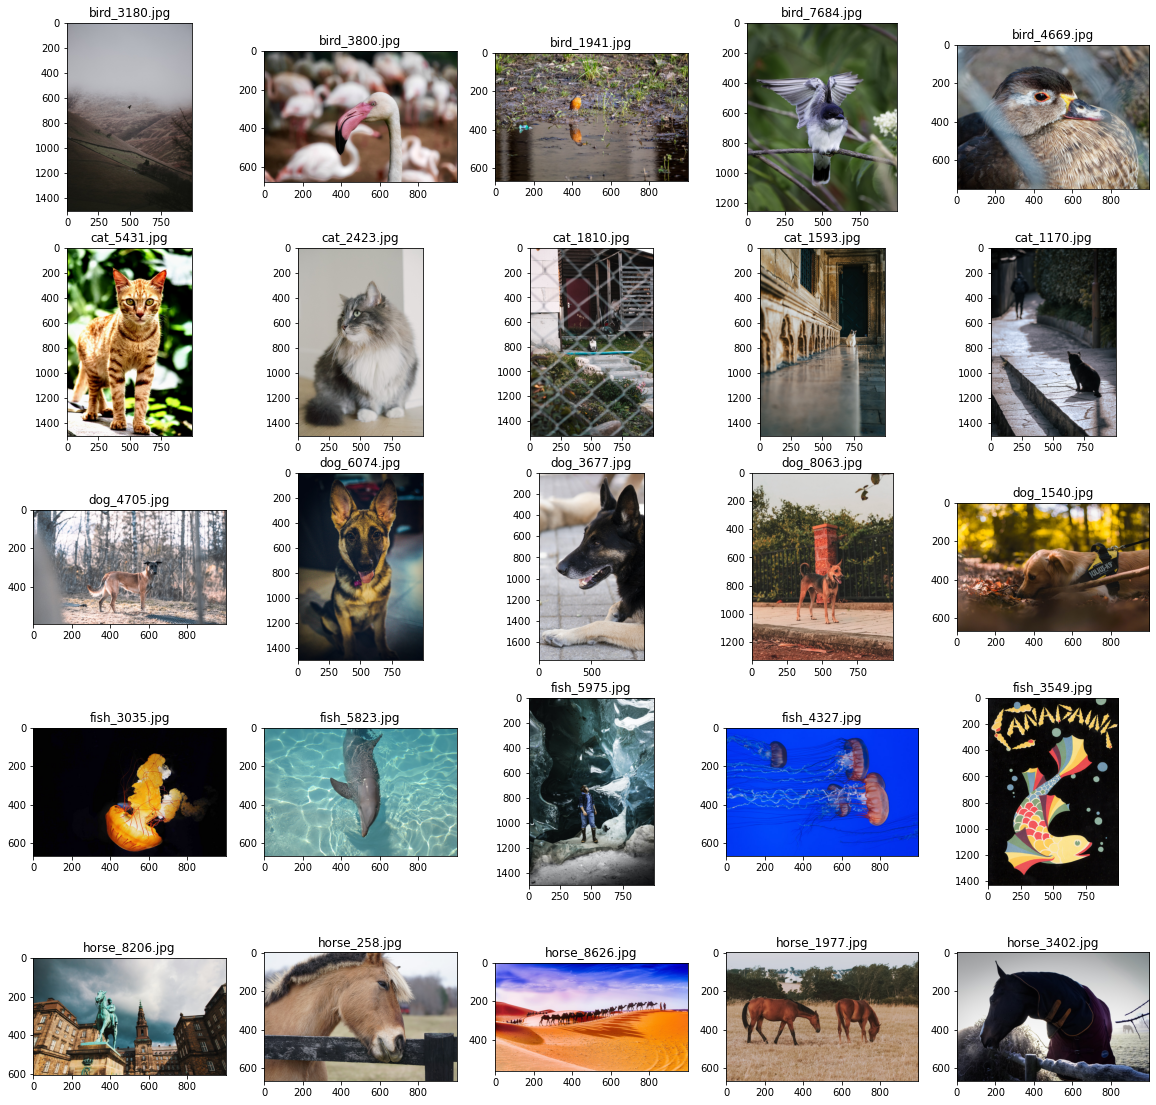

In [3]:
print("Beispiel-Bilder vom Datensatz:")
plt.figure(figsize=(20,20))
animals = ["bird","cat","dog","fish","horse"]
k = 0
random.seed(4)

for animal in animals:
    test_folder="Data/train/"+animal
    
    for i in range(5):
        file = random.choice(os.listdir(test_folder))
        image_path= os.path.join(test_folder, file)
        img=mpimg.imread(image_path)
        ax=plt.subplot(5,5,k+1)
        ax.title.set_text(file)
        plt.imshow(img)
        k = k+1    

##### Beobachtung:

- Die Bilder haben eine hohe Auflösung
- Die Tiere sind meistens gut erkennbar
- Tiere sind nicht immer zentriert
- Manchmal mehrere Objekte in einem Bild
- Fokus nicht immer beim Tier
- Unterschiedliche Formate

### 1.3 Preprocess and load Data

Die Bilder wurden in Train, Valid und Test aufgeteilt die in unterschiedlichen Ordnern lokal abgelegt worden sind.
Mit einer Funktion wollen wir auf den passenden Ordner zugreifen und mit einem definierten Batch_size reinladen. Im gleichen Schritt wollen wir die Bilder einheitlich skalieren (resize) und normalisieren. Das Normalisieren hilft, dass der CNN besser performt.
Die Auswahl der Grösse der Bilder hängt stark mit dem Netwerk und dem GPU zusammen, mit dem man arbeitet. Für den Anfang werden wir die Bilder runter skalieren auf eine Dimension von 32x32.


In [2]:
def image_loader(image_size=32, batch_size=32, root="Images/",num_workers=8,shuffle=False):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    data_set = torchvision.datasets.ImageFolder(root=root, transform=transform)
    data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers,pin_memory=True)

    return data_loader

classes = ["bird","cat","dog","fish","horse"]

## 2. Define the Modell

### 2.1 Metrics

Zu Beginn visualisieren wir eine Konfusionsmatrix und können sehen, wie sich das Modell sich erhält und welche Werte wir ablesen können. Daraus leiten wir dann die folgenden Metriken ab und können die verschiedenen Modelle später vergleichen.

$$Precision = \frac{TP} {TP+FP}$$

$$Recall = \frac{TP} {TP+FN}$$

$$F_1 =\big{(}\frac{1/Precision+1/Recall} {2}\big{)}^{-1}$$

Precision wird wie in der oben gezeigten Gleichung berechnet und gibt den Anteil der korrekt vorhergesagten positiven Ergebnisse (TP) im Verhältnis zur Summe aller positiv vorhergesagten Ergebnisse (P) an.
Der Recall gibt den Anteil der korrekt als positiv eingestuften Ergebnisse (TP) an der Gesamtheit der tatsächlich positiven Ergebnisse (P) an. Der F1-Score ist die harmonische Mitte aus Precision und Recall und wird oft als zusammenfassende Metrik verwendet. Daher werden wir hauptsächlich F1-Score als unsere Metrik für den vergleich unterschiedlicher Modelle verwenden.

Zudem werden wir beim Trainieren der Modelle mit Accuracy und Mean absolute error (L1 Loss) arbeiten:

$$Accuracy = \frac{Anzahl richtige Vorhersagen} {Anzahl gemachte Vorhersagen}$$

$$MeanAbsoluteError = \frac{\sum_{i=1}^n|y_i-\hat{y}_i|} {n}$$






### 2.2 Basic functionality

#### 2.2.1 Device

Ich werde alle Modelle auf der GPU trainieren lassen damit die Rechenzeit reduziert wird.
Diese GPU wird verwendet fürs Training:

In [5]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3060'

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#### 2.2.2 Architektur unseres CNN-Modells:

Mit Hilfe von TorchVision kann man mit wenig Code bereits ein vortrainiertes Netzwerk wie "AlexNet" oder "ResNet" laden und damit weiterarbeiten. Die Haupt-Layers in einem CNN sind die Coevolution und Maxpooling Layers. Das Modell, das ich verwenden werde hat einen folgenden Aufbau:
1. convolutional layer
2. Max Pooling Layer
3. convolutional layer
4. NN connected layer
5. NN connected layer
6. NN connected layer

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(model, iterator, optimizer, criterion, device, regularizer = None):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()    
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        if regularizer == "L1":
            l1_l_c = nn.L1Loss()
            l1_lambda = 0.01
            l1_norm = 0
            for parameter in model.parameters():
                l1_norm += l1_l_c(parameter,target=torch.zeros_like(parameter))
            l1 = l1_lambda * l1_norm
            # Add L1 loss component
            loss += l1
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [6]:
def evaluate(model, iterator, criterion, device, regularizer = None):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)
            if regularizer == "L1":
                l1_l_c = nn.L1Loss()
                l1_lambda = 0.01
                l1_norm = 0
                for parameter in model.parameters():
                    l1_norm += l1_l_c(parameter,target=torch.zeros_like(parameter))
                l1 = l1_lambda * l1_norm
                # Add L1 loss component
                loss += l1

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [7]:
def epoch_time(start, end):
    elapsed_time = end - start
    elapsed_in_min = int(elapsed_time / 60)
    elapsed_in_sec = int(elapsed_time - (elapsed_in_min * 60))
    return elapsed_in_min, elapsed_in_sec

In [8]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    accuracy = correct.float() / y.shape[0]
    return accuracy

In [9]:
def train_epoch(epochs, model, trainloader, optimizer, criterion, device, regularizer = None):
   
    train_losses = []
    train_accuracy = []
    valid_losses = []
    valid_accuracy = []
    best_valid_loss = float('inf')
    for epoch in range(epochs):
        
        start_time = time.monotonic()

        train_loss, train_acc = train(model, trainloader, optimizer, criterion, device, regularizer = regularizer)
        valid_loss, valid_acc = evaluate(model, valloader, criterion, device, regularizer = regularizer)

        end_time = time.monotonic()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accuracy.append(valid_acc)
        
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s || Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% || Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    return model, train_losses, train_accuracy, valid_losses, valid_accuracy

In [10]:
def metric_evaluation(y_test, y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    
    fig = plt.subplots(figsize=(20, 5))
    plt.subplot(1,2,1)
    p1 = sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=classes,yticklabels=classes, cmap="YlGnBu")
    p1.set_title('Confusion Matrix')
    p1.set_ylabel('True')
    p1.set_xlabel('Predicted')

    plt.subplot(1,2,2)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    metric_names = ['Recall Macro', 'Precision Macro', 'F1 Macro']
    metrics = [recall, precision, f1]

    p2 = sns.barplot(x=metric_names, y=metrics,palette="Blues_d")
    for i, value in enumerate(metrics):
        plt.text(x=i, y=value, s=str(round(value,3)), ha='center')
    p2.set_ylim(0,1) 
    p2.set_title('metrics')
    p2.set_ylabel('Score')
    sns.despine()

    plt.show()

In [11]:
def get_predictions(model, iterator, device):
    
    model.eval()
    images = []
    labels = []
    probs = []
    
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y_pred = model(x)
            
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [12]:
def loss_acc_function(train_loss,valid_loss,train_acc,valid_acc):
    
    fig = plt.subplots(figsize=(15, 5))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label='Training loss')
    plt.plot(valid_loss, label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    
    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(valid_acc, label='Validation accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.show()

## 3. Training with SGD (without REG, without BN)

### 3.1 Model 1

Als erstes Model nehmen wir für den SGD einen Batchgrösse von 32 Bildern in 10 Epochen. Die Learning Rate dabei beträgt 0.001.
Die Anzahl "Workers" wurde bereits in mehreren Versuchen angepasst und bei der Zahl 8 die schnellsten Resultate erzielt. Unsere Parameter sind:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001

In [45]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [46]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 33s || Train Loss: 1.582 | Train Acc: 26.77% || Val. Loss: 1.511 |  Val. Acc: 31.54%
Epoch: 02 | Epoch Time: 2m 34s || Train Loss: 1.465 | Train Acc: 36.41% || Val. Loss: 1.429 |  Val. Acc: 37.18%
Epoch: 03 | Epoch Time: 2m 52s || Train Loss: 1.416 | Train Acc: 39.48% || Val. Loss: 1.405 |  Val. Acc: 39.20%
Epoch: 04 | Epoch Time: 2m 33s || Train Loss: 1.394 | Train Acc: 41.16% || Val. Loss: 1.395 |  Val. Acc: 40.92%
Epoch: 05 | Epoch Time: 2m 38s || Train Loss: 1.374 | Train Acc: 42.62% || Val. Loss: 1.370 |  Val. Acc: 43.54%
Epoch: 06 | Epoch Time: 2m 38s || Train Loss: 1.359 | Train Acc: 43.39% || Val. Loss: 1.361 |  Val. Acc: 42.27%
Epoch: 07 | Epoch Time: 2m 34s || Train Loss: 1.347 | Train Acc: 44.09% || Val. Loss: 1.345 |  Val. Acc: 43.59%
Epoch: 08 | Epoch Time: 2m 31s || Train Loss: 1.334 | Train Acc: 44.64% || Val. Loss: 1.332 |  Val. Acc: 44.43%
Epoch: 09 | Epoch Time: 2m 32s || Train Loss: 1.322 | Train Acc: 45.31% || Val. Loss: 1.324 |  Val. Acc:

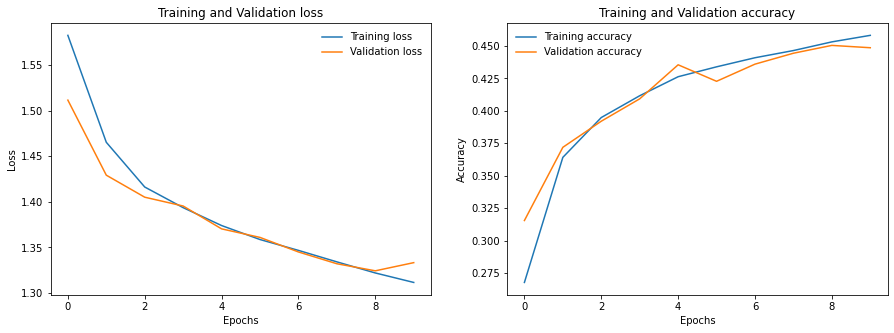

In [47]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Die Grafik zeigt den Loss der einzelnen Epochen während des Trainierens. Die Kurve zeigt eine schwache Learning Rate. Um ein besseres Ergebnis hier zu bekommen, könnte man die Anzahl Epochen erhöhen und/oder die Learning Rate.

Der Grund für die niedrige Anzahl der Epochen ist die lange Trainingszeit obwohl dies auf der GPU läuft. Anschliessend würden wir das Modell auf den den Datensatz testen, dass das Modell noch nie gesehen hat.

In [19]:
PATH= "SGD_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [17]:
PATH= "SGD_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.341 | Test Acc: 44.38%


In [19]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_10ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

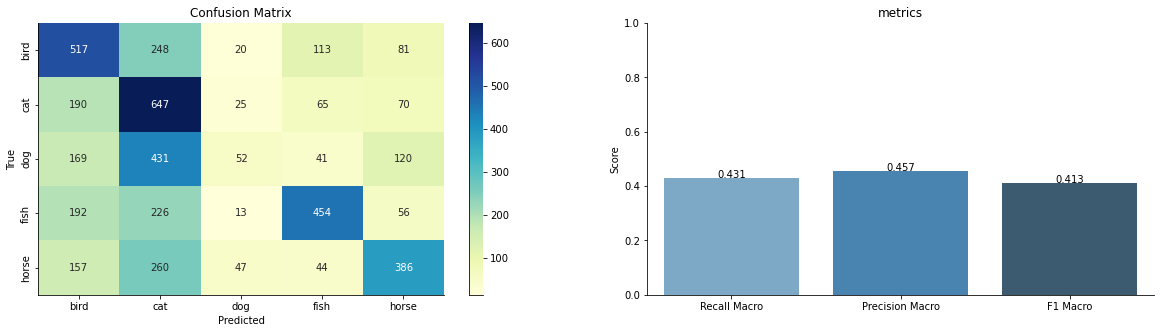

In [23]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Im der Confusion Matrix können wir erkennen, dass es vor allem sehr Mühe hat die Hunde ("dog") richtig zu vorhersagen. Die Verwechslung zu Katze ("cat") ist hier besonders hoch.

Der F1 score mit einem Wert von 0.41 ist nicht hoch. zumindest kann man aber sage, dass es besser ist als der Zufall.


### 3.2 Model 2

Als nächstes Model nehmen wir die gleichen Parameter, ausser mit einer Batchgrösse von 64. Vielleicht können wir unterschiede erkennen:
- Anzahl Worker = 8
- Batchgrösse = 64
- Epochen = 10
- Learningrate = 0.001

In [48]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 64
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [49]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 30s || Train Loss: 1.607 | Train Acc: 21.18% || Val. Loss: 1.605 |  Val. Acc: 21.10%
Epoch: 02 | Epoch Time: 2m 29s || Train Loss: 1.596 | Train Acc: 26.59% || Val. Loss: 1.567 |  Val. Acc: 27.80%
Epoch: 03 | Epoch Time: 2m 29s || Train Loss: 1.522 | Train Acc: 30.36% || Val. Loss: 1.493 |  Val. Acc: 32.63%
Epoch: 04 | Epoch Time: 2m 30s || Train Loss: 1.475 | Train Acc: 35.25% || Val. Loss: 1.448 |  Val. Acc: 35.56%
Epoch: 05 | Epoch Time: 2m 31s || Train Loss: 1.434 | Train Acc: 37.89% || Val. Loss: 1.423 |  Val. Acc: 37.34%
Epoch: 06 | Epoch Time: 2m 31s || Train Loss: 1.414 | Train Acc: 39.32% || Val. Loss: 1.406 |  Val. Acc: 38.53%
Epoch: 07 | Epoch Time: 2m 30s || Train Loss: 1.400 | Train Acc: 40.57% || Val. Loss: 1.397 |  Val. Acc: 39.93%
Epoch: 08 | Epoch Time: 2m 30s || Train Loss: 1.388 | Train Acc: 41.62% || Val. Loss: 1.387 |  Val. Acc: 41.40%
Epoch: 09 | Epoch Time: 2m 31s || Train Loss: 1.378 | Train Acc: 42.41% || Val. Loss: 1.373 |  Val. Acc:

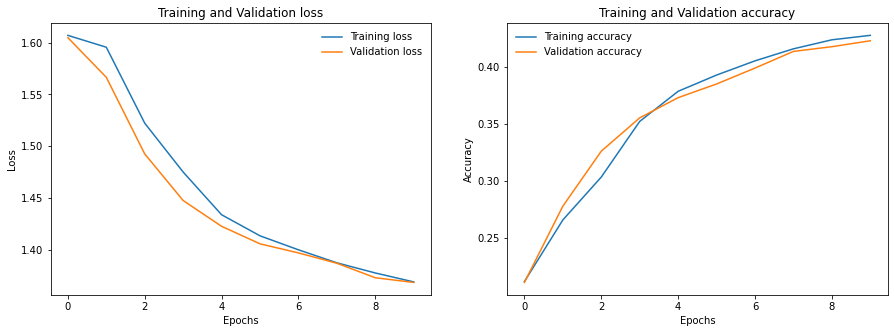

In [50]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Die Grafik zeigt ein sehr ähnliches Bild wie das mit einer Batchgrösse von 32. Auch hier sehen wir noch Potenzial mit mehr Epochen.



In [27]:
PATH= "SGD_64ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [21]:
PATH= "SGD_64ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.388 | Test Acc: 42.34%


In [23]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_64ba_10ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

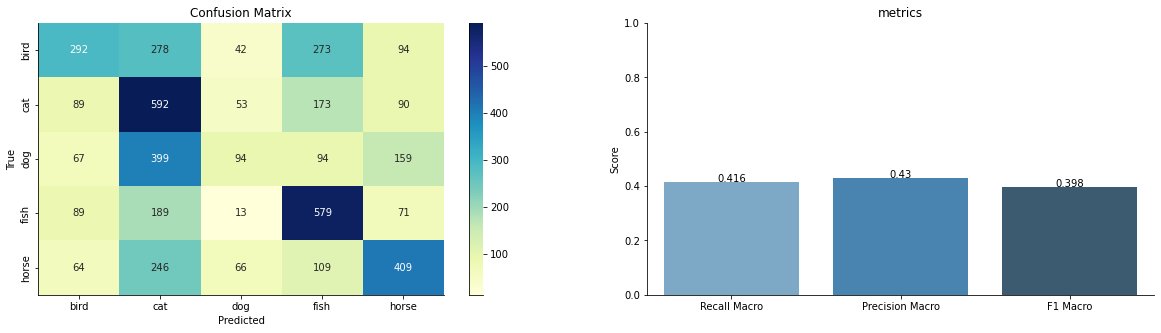

In [31]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Dieses Modell zeigt die gleichen Tücken auf wie das erste Modell. Der F1 Score liegt jetzt sogar unter 0.4. In Zukunft bleiben wir lieber mit einer Batchgrösse von 32.


### 3.3 Model 3

Das Trainieren geht sehr lange, aber doch würde es uns interessieren wie das Modell sich entwickelt, wenn wir noch mehr Durchläufe (Epochen) abspielen. Wir nehmen uns die Zeit und machen 20 Epochen:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 20
- Learningrate = 0.001

In [51]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 20
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [52]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 28s || Train Loss: 1.601 | Train Acc: 25.41% || Val. Loss: 1.584 |  Val. Acc: 27.16%
Epoch: 02 | Epoch Time: 2m 27s || Train Loss: 1.519 | Train Acc: 32.73% || Val. Loss: 1.472 |  Val. Acc: 34.81%
Epoch: 03 | Epoch Time: 2m 29s || Train Loss: 1.446 | Train Acc: 37.55% || Val. Loss: 1.428 |  Val. Acc: 38.50%
Epoch: 04 | Epoch Time: 2m 31s || Train Loss: 1.412 | Train Acc: 39.80% || Val. Loss: 1.401 |  Val. Acc: 40.95%
Epoch: 05 | Epoch Time: 2m 31s || Train Loss: 1.393 | Train Acc: 41.01% || Val. Loss: 1.409 |  Val. Acc: 40.35%
Epoch: 06 | Epoch Time: 2m 31s || Train Loss: 1.381 | Train Acc: 42.02% || Val. Loss: 1.387 |  Val. Acc: 42.46%
Epoch: 07 | Epoch Time: 2m 31s || Train Loss: 1.370 | Train Acc: 42.78% || Val. Loss: 1.372 |  Val. Acc: 42.99%
Epoch: 08 | Epoch Time: 2m 31s || Train Loss: 1.362 | Train Acc: 43.04% || Val. Loss: 1.366 |  Val. Acc: 43.74%
Epoch: 09 | Epoch Time: 2m 31s || Train Loss: 1.351 | Train Acc: 43.75% || Val. Loss: 1.357 |  Val. Acc:

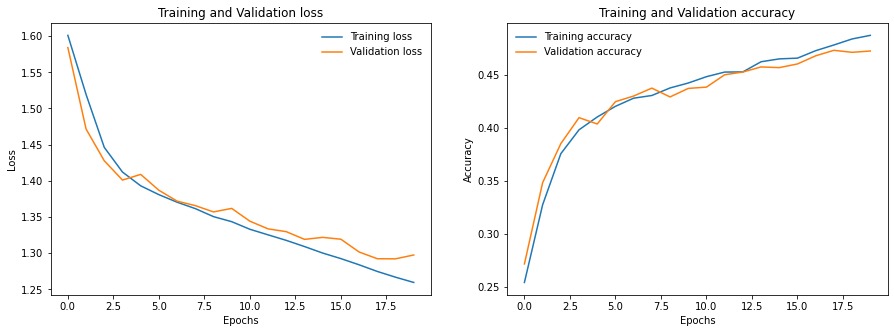

In [53]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Mit mehr Epochen wird der Loss kleiner und Accuracy steigt. Zwar distanzieren sich Train und Validation mehr mit jeder weiteren Epoche, aber die Resultate werden besser.

In [36]:
PATH= "SGD_32ba_20ep_001lr"
torch.save(model.state_dict(), PATH)

In [25]:
PATH= "SGD_32ba_20ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [26]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.281 | Test Acc: 48.17%


In [27]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_20ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

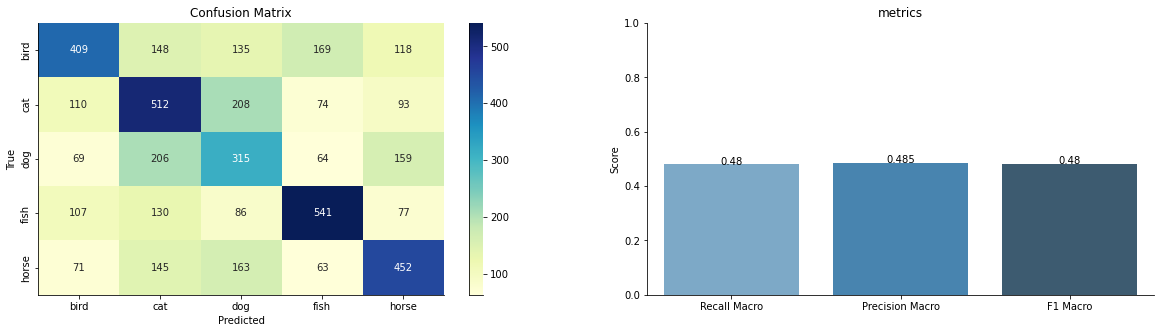

In [20]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Mehr Epochen haben echt was gebracht. Bei der Confusion Matrix sehen wir, dass wir nicht mehr so viele Hunde falsch vorhergesagt werden. Auch der F1 Score hat sich deutlich verbessert.

### 3.4 Model 4

Als nächstes Modell würden wir vorallem mit dem Learningrate spielen. statt eine Learningrate von 0.001 nehmen wir 0.01. Mal schauen wie sich das Modell dementsprechend ändern. Die Anzahl Epochen ändern wir wieder auf 10, damit wir es direkter vergleichen können mit d em ersten Modell:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.01

In [54]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.01

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [55]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 34s || Train Loss: 1.471 | Train Acc: 35.77% || Val. Loss: 1.399 |  Val. Acc: 40.61%
Epoch: 02 | Epoch Time: 2m 32s || Train Loss: 1.376 | Train Acc: 42.57% || Val. Loss: 1.362 |  Val. Acc: 42.46%
Epoch: 03 | Epoch Time: 2m 32s || Train Loss: 1.342 | Train Acc: 44.46% || Val. Loss: 1.333 |  Val. Acc: 44.95%
Epoch: 04 | Epoch Time: 2m 33s || Train Loss: 1.310 | Train Acc: 46.23% || Val. Loss: 1.301 |  Val. Acc: 46.90%
Epoch: 05 | Epoch Time: 2m 33s || Train Loss: 1.288 | Train Acc: 47.53% || Val. Loss: 1.315 |  Val. Acc: 46.10%
Epoch: 06 | Epoch Time: 2m 32s || Train Loss: 1.261 | Train Acc: 48.97% || Val. Loss: 1.282 |  Val. Acc: 48.19%
Epoch: 07 | Epoch Time: 2m 31s || Train Loss: 1.241 | Train Acc: 49.86% || Val. Loss: 1.315 |  Val. Acc: 46.41%
Epoch: 08 | Epoch Time: 2m 31s || Train Loss: 1.215 | Train Acc: 51.39% || Val. Loss: 1.318 |  Val. Acc: 45.64%
Epoch: 09 | Epoch Time: 2m 31s || Train Loss: 1.191 | Train Acc: 52.27% || Val. Loss: 1.280 |  Val. Acc:

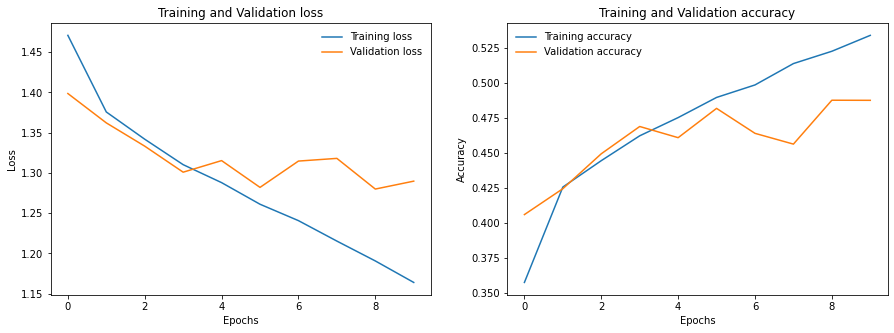

In [56]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Wir sehen das durch einen Learningrate von 0.01 zwar besser Resultate erzielt werden, aber es sieht so aus als wäre der Learningrate für den Validationloss zu gross.

In [47]:
PATH= "SGD_32ba_10ep_01lr"
torch.save(model.state_dict(), PATH)

In [48]:
PATH= "SGD_32ba_10ep_01lr"
torch.save(model.state_dict(), PATH)

In [49]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.321 | Test Acc: 47.41%


In [50]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_SGD_32ba_10ep_01lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

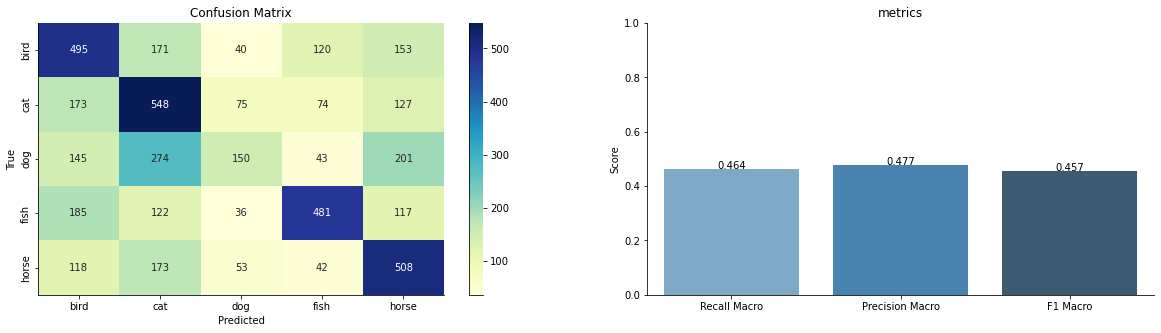

In [28]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Mit dem Test-Datensatz bekommen wir bessere Werte in den Metriken mit einem Learningrate von 0.01. Dies würden wir im Hinterkopf behalten und später wieder draufzukommen

### 3.5 Model 5

Wir können vielleicht bessere Ergebnisse erzielen mit einem anderen Netzwerk? Wie wäre es, wenn wir die Parameter unseres ersten Modells beibehalten aber die Architektur des Modells von AlexNet nehmen. Damit dieses Network erhöhen wir Grösse der Input-Bilder auf 224x224. Die Parameter sind folgende:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001

In [14]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

In [58]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(image_size = 224, batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(image_size = 224,batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(image_size = 224,batch_size = batch_size,root=test_path,shuffle=False)

model = AlexNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [59]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 48s || Train Loss: 2.184 | Train Acc: 21.90% || Val. Loss: 1.649 |  Val. Acc: 23.38%
Epoch: 02 | Epoch Time: 2m 48s || Train Loss: 1.486 | Train Acc: 34.55% || Val. Loss: 1.538 |  Val. Acc: 33.64%
Epoch: 03 | Epoch Time: 2m 49s || Train Loss: 1.392 | Train Acc: 41.64% || Val. Loss: 1.338 |  Val. Acc: 43.11%
Epoch: 04 | Epoch Time: 2m 48s || Train Loss: 1.329 | Train Acc: 45.17% || Val. Loss: 1.293 |  Val. Acc: 46.64%
Epoch: 05 | Epoch Time: 2m 49s || Train Loss: 1.275 | Train Acc: 47.92% || Val. Loss: 1.275 |  Val. Acc: 47.90%
Epoch: 06 | Epoch Time: 2m 47s || Train Loss: 1.236 | Train Acc: 50.19% || Val. Loss: 1.257 |  Val. Acc: 47.95%
Epoch: 07 | Epoch Time: 2m 47s || Train Loss: 1.186 | Train Acc: 52.73% || Val. Loss: 1.161 |  Val. Acc: 53.96%
Epoch: 08 | Epoch Time: 2m 46s || Train Loss: 1.147 | Train Acc: 54.70% || Val. Loss: 1.151 |  Val. Acc: 54.35%
Epoch: 09 | Epoch Time: 2m 45s || Train Loss: 1.108 | Train Acc: 56.63% || Val. Loss: 1.118 |  Val. Acc:

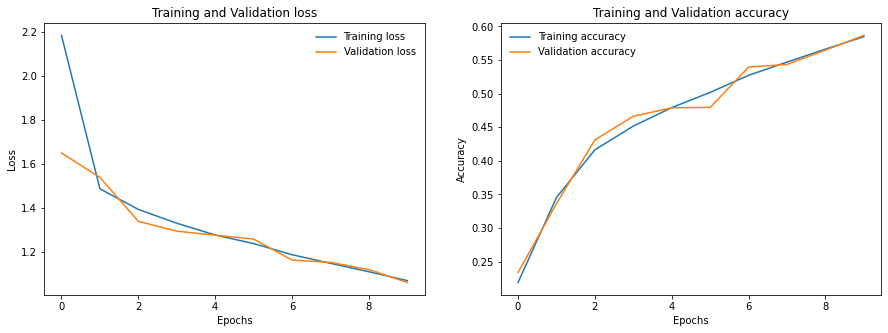

In [60]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Das Alexnet performt bereits jetzt schon sehr gut. Der Loss der Training und Validation sind bereit nach 10 Epochen und 1.2.

In [136]:
PATH= "AlexNet_SGD_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [37]:
PATH= "AlexNet_SGD_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [38]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.154 | Test Acc: 55.50%


In [39]:
images, labels, probs = get_predictions(model, testloader, device)
pred_labels = torch.argmax(probs, 1)
f1_AlexNet_SGD_32ba_10ep_001lr = f1_score(labels, pred_labels, average='macro', zero_division=0)

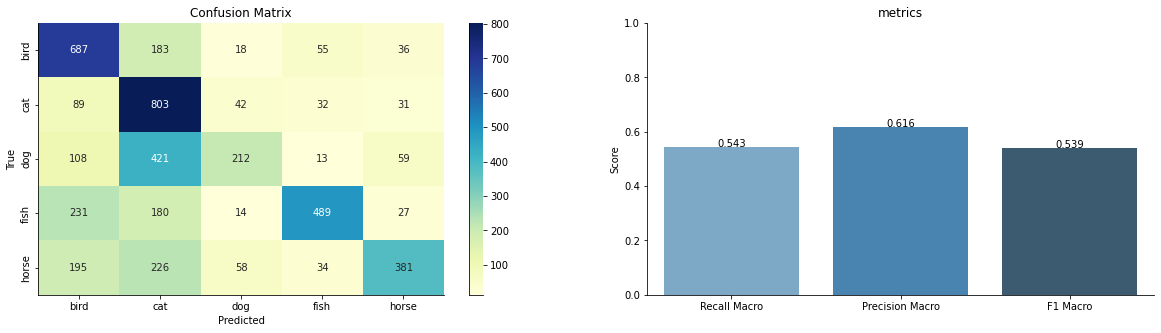

In [135]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Da dieses Modell besser performt ist deutlich an den Metriken zu erkennen. Wir konnten einen F1 Score über 0.5 erreichen. Werden wir dieses mit unserem Netzwerk mit verschiedenen Ansätzen schlagen können?

## 3.6 Vergleich der Modelle:

Hier ein direkter Vergleich der ersten Modelle die wir bis jetzt haben mit dem F1 Score:

In [59]:
f1_metrics= ["SGD 32ba 10ep 0.001lr","SGD 64ba 10ep 0.001lr", "SGD 32ba 20ep 0.001lr", "SGD 32ba 10ep 0.01lr", "AlexNet SGD 32ba 10ep 0.001lr"]
f1_values = [f1_SGD_32ba_10ep_001lr, f1_SGD_64ba_10ep_001lr,f1_SGD_32ba_20ep_001lr, f1_SGD_32ba_10ep_01lr, f1_AlexNet_SGD_32ba_10ep_001lr]

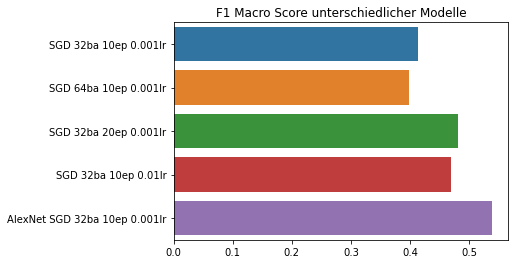

In [62]:
sns.barplot(x=f1_values, y=f1_metrics)
plt.title("F1 Macro Score unterschiedlicher Modelle")
plt.show()

Beobachtung

Beim direkten Vergleich kann man schnell erkennen was die wichtigen Erkenntnisse daraus sind. Nochmals zusammengefasst können wir sagen:
- Batchsize 32 ist besser als Batchsize 64
- Mehr Epochen können kann helfen das Modell besser zu trainieren
- Learningrate von 0.1 performt besser als 0.001
- AlexNet ist deutlich besser als unser Netzwerk

    

## 4. Benefits of Regularization

Regularisierung ist eine wichtige Technik, die bei Deep Learning angewendet wird. Sie verhindert ein Overfitting der Model, indem sie die Komplexität des neuronalen Netzwerks tief hält. Wie auch im oberen in der Grafik sichtbar war, kommt es oft vor, dass das Modell gut auf den Trainiersatz perform aber schlechter auf den Testdaten. Dies bedeutet, dass das Modell schlecht die Outputs vorhersagen kann, wenn er noch nie die Daten gesehen hat, weil es einen gewissen Noise ins Modell mitgibt und somit das es sozusagen Overfittet ist. Dieses Problem kann mit Hilfe der Regularisierungstechniken gelöst werden. Diese Techniken können so verwendet werden, dass alle Variablen oder Merkmale eines Modells beibehalten werden können, indem die Größe der Variablen reduziert wird. Somit hat man immer noch die gleiche Accuracy und behält trotzdem die Verallgemeinerung des Modells.

### 4.1 Different regularization methods

Es gibt drei sehr beliebte und effiziente Regularisierungstechniken namens L1, L2 und Dropout, die wir genauer anschauen werden.

#### 4.1.1 L2 Regularization
Die L2-Regularisierung ist einer der beliebtesten aller Regularisierungstechniken und wird auch Ride Regression bezeichnet. Beim L2-Regularisierung wird die Loss Function des neuralen Netzwerkes um einen sogenannten Regularisierungsterm erweitert:

$$\textrm{Cost function} = \textrm{Loss}+\frac{\lambda}{2m}*\sum ||w||^2$$

Hier ist Lambda der Regularisierungsparameter. Es ist der Hyperparameter, dessen Wert für bessere Ergebnisse optimiert ist. Die L2-Regularisierung reduziert dadurch die Weights (Die Werte gehen gegen Null).

L2 Regularization wird hauptsächlich verwendet, um das Overfitting im Modell zu reduzieren und umfasst alle im Modell vorhandenen Funktionen. Es reduziert die Komplexität des Modells, indem es die Koeffizienten verkleinert.

#### 4.1.2 L1 Regularization

Auch bekannt als Lasso Regression ist ähnelt wie der Ridge Regression, außer dass der Strafterm $w$ nur die absoluten Gewichte anstelle eines Quadrats der Gewichte enthält.

$$\textrm{Cost function} = \textrm{Loss}+\frac{\lambda}{2m}*\sum ||w||$$

Da es auch absolute Werte annimmt, kann es die Steigung bis auf 0 verkleinern.

L1 Regularization hilft, das Overfitting im Modell sowie die Feature Selection zu reduzieren.

#### 4.1.3 L1 Dropout

Beim Dropout werden Neuronen während des Trainierens eines zufälligen Satzes ignoriert. Mit „ignorieren“ meint man, dass diese Neuronen bei einem bestimmten forward - oder backward pass nicht berücksichtigt werden.
Eine vollständig verbundene layer belegt die meisten Parameter und daher entwickeln Neuronen während des Trainings eine Co-Abhängigkeit untereinander, was die individuelle Leistung jedes Neurons einschränkt und zu einem Overfitting der Trainingsdaten führt. Genau das möchten wird mit dem Dropout verhindern

### 4.2 Evaluation

### 4.2.1 Model 6

Als erste Regularisierungen nehmen wir den L1. Die Parameter sind:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001
- Regularisierung = L1 (Lambda: 0.01)

In [61]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [62]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device, regularizer = "L1")

Epoch: 01 | Epoch Time: 2m 28s || Train Loss: 1.584 | Train Acc: 25.89% || Val. Loss: 1.525 |  Val. Acc: 28.81%
Epoch: 02 | Epoch Time: 2m 27s || Train Loss: 1.503 | Train Acc: 32.38% || Val. Loss: 1.474 |  Val. Acc: 34.63%
Epoch: 03 | Epoch Time: 2m 28s || Train Loss: 1.459 | Train Acc: 36.77% || Val. Loss: 1.440 |  Val. Acc: 37.97%
Epoch: 04 | Epoch Time: 2m 28s || Train Loss: 1.424 | Train Acc: 39.28% || Val. Loss: 1.407 |  Val. Acc: 39.62%
Epoch: 05 | Epoch Time: 2m 31s || Train Loss: 1.402 | Train Acc: 40.96% || Val. Loss: 1.393 |  Val. Acc: 41.04%
Epoch: 06 | Epoch Time: 2m 34s || Train Loss: 1.385 | Train Acc: 42.08% || Val. Loss: 1.382 |  Val. Acc: 41.69%
Epoch: 07 | Epoch Time: 2m 31s || Train Loss: 1.371 | Train Acc: 43.08% || Val. Loss: 1.368 |  Val. Acc: 42.93%
Epoch: 08 | Epoch Time: 2m 31s || Train Loss: 1.356 | Train Acc: 44.23% || Val. Loss: 1.355 |  Val. Acc: 43.54%
Epoch: 09 | Epoch Time: 2m 31s || Train Loss: 1.345 | Train Acc: 44.66% || Val. Loss: 1.348 |  Val. Acc:

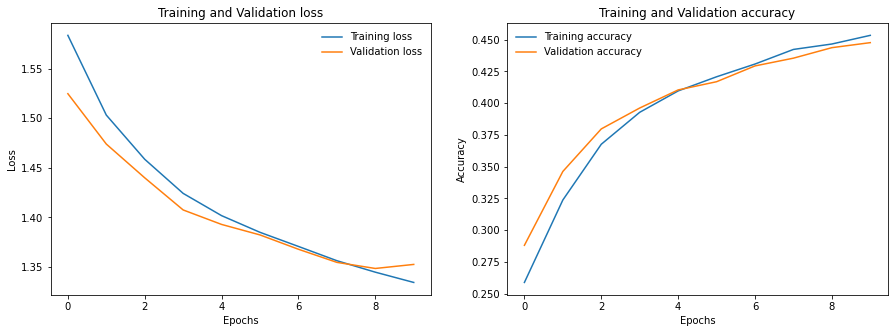

In [63]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Die Lossfunktion mit der L1 Regularisierung zeigt kaum Veränderungen auf den ersten Blick im Vergleich mit dem ersten Modell mit den gleichen Parameter ohne Regularisierung.

In [43]:
PATH= "SGD_L1_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [44]:
PATH= "SGD_L1_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [45]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.323 | Test Acc: 45.91%


In [46]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

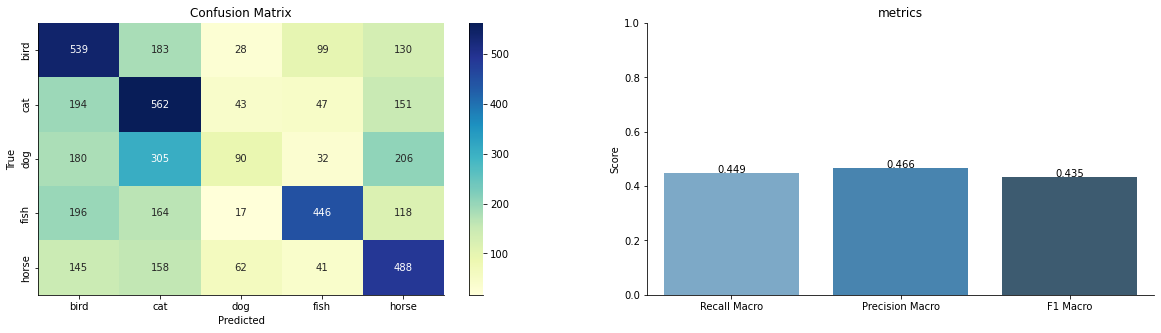

In [47]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Auch hier sieht man immer noch die Schwierigkeit beim Erkennen der Klasse der Hunde. Der F1 Score ist aber mit der Regularisierung tatsächlich ein kleines Stück besser

### 4.2.2 Model 7
Als nächste Regularisierungen nehmen wir den L2. Die Parameter sind:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001
- Regularisierung = L2 (weight_decay=0.001)

In [64]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)

In [65]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 30s || Train Loss: 1.605 | Train Acc: 23.19% || Val. Loss: 1.601 |  Val. Acc: 26.23%
Epoch: 02 | Epoch Time: 2m 30s || Train Loss: 1.564 | Train Acc: 30.82% || Val. Loss: 1.502 |  Val. Acc: 34.35%
Epoch: 03 | Epoch Time: 2m 29s || Train Loss: 1.470 | Train Acc: 35.83% || Val. Loss: 1.444 |  Val. Acc: 36.79%
Epoch: 04 | Epoch Time: 2m 29s || Train Loss: 1.419 | Train Acc: 39.60% || Val. Loss: 1.392 |  Val. Acc: 40.73%
Epoch: 05 | Epoch Time: 2m 30s || Train Loss: 1.385 | Train Acc: 41.88% || Val. Loss: 1.395 |  Val. Acc: 40.82%
Epoch: 06 | Epoch Time: 2m 30s || Train Loss: 1.368 | Train Acc: 42.85% || Val. Loss: 1.364 |  Val. Acc: 43.10%
Epoch: 07 | Epoch Time: 2m 32s || Train Loss: 1.352 | Train Acc: 43.75% || Val. Loss: 1.353 |  Val. Acc: 43.28%
Epoch: 08 | Epoch Time: 2m 30s || Train Loss: 1.340 | Train Acc: 44.05% || Val. Loss: 1.334 |  Val. Acc: 44.44%
Epoch: 09 | Epoch Time: 2m 30s || Train Loss: 1.328 | Train Acc: 45.10% || Val. Loss: 1.336 |  Val. Acc:

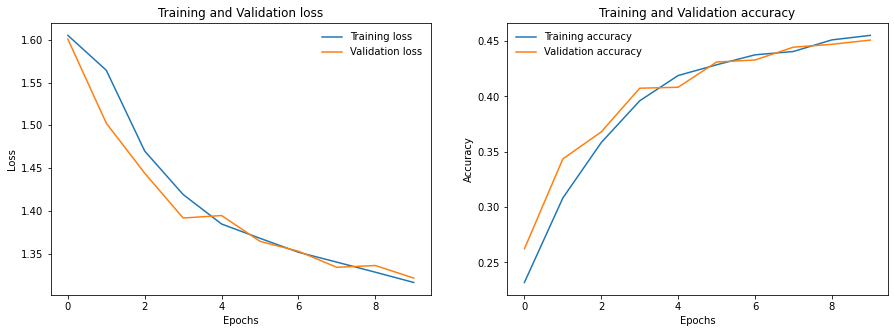

In [66]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Die Lossfunktion mit der L2 Regularisierung zeigt ebenfalls ein sehr ähnliches Bild wie bei den Vorherigen Modellen. Die Kurven verlaufen sehr sauber und parallel zueinander. Auch hier sieht man noch viel Potenzial mit mehr Epochen.

In [51]:
PATH= "SGD_L2_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [52]:
PATH= "SGD_L2_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [53]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.333 | Test Acc: 45.62%


In [54]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

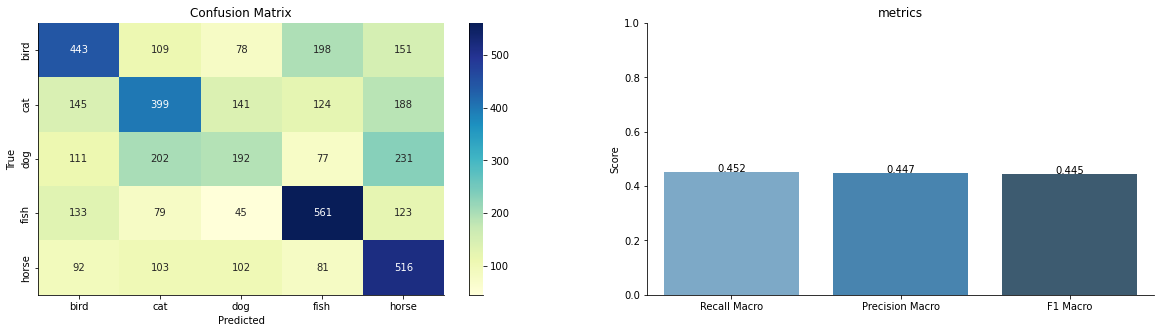

In [55]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Hier sieht man noch mal eine Verbesserung der L2 Regularisierung im Vergleich zu L1. Auch ist ein Fortschritt bei der Vorhersage der Klasse der Hunde sichtbar.


### 4.2.3 Model 8

Als letzte Regularisierungen nehmen wir den Dropout. Die Parameter sind:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001
- Regularisierung = Dropout(0.25)

In [67]:
class Drop_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)
        
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Apply dropout
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    

In [68]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=test_path,shuffle=False)

model = Drop_Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [69]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 42s || Train Loss: 1.596 | Train Acc: 25.87% || Val. Loss: 1.561 |  Val. Acc: 30.34%
Epoch: 02 | Epoch Time: 2m 23s || Train Loss: 1.503 | Train Acc: 34.32% || Val. Loss: 1.465 |  Val. Acc: 35.75%
Epoch: 03 | Epoch Time: 2m 23s || Train Loss: 1.444 | Train Acc: 37.97% || Val. Loss: 1.421 |  Val. Acc: 38.96%
Epoch: 04 | Epoch Time: 2m 24s || Train Loss: 1.414 | Train Acc: 40.03% || Val. Loss: 1.403 |  Val. Acc: 40.88%
Epoch: 05 | Epoch Time: 2m 24s || Train Loss: 1.396 | Train Acc: 40.95% || Val. Loss: 1.384 |  Val. Acc: 41.39%
Epoch: 06 | Epoch Time: 2m 24s || Train Loss: 1.383 | Train Acc: 42.15% || Val. Loss: 1.382 |  Val. Acc: 41.64%
Epoch: 07 | Epoch Time: 2m 25s || Train Loss: 1.373 | Train Acc: 42.64% || Val. Loss: 1.364 |  Val. Acc: 42.55%
Epoch: 08 | Epoch Time: 2m 24s || Train Loss: 1.364 | Train Acc: 43.32% || Val. Loss: 1.366 |  Val. Acc: 43.22%
Epoch: 09 | Epoch Time: 2m 26s || Train Loss: 1.355 | Train Acc: 43.80% || Val. Loss: 1.351 |  Val. Acc:

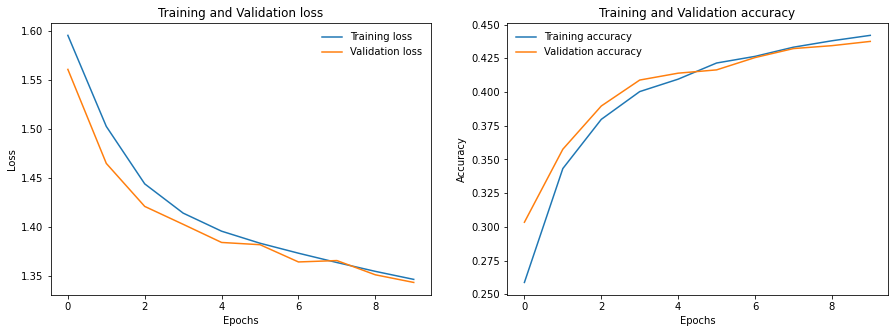

In [70]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Auch hier sieht man gut, dass Train und Validation Werte stark miteinander verlaufen und wir kein Overfitting haben.

In [60]:
PATH= "SGD_Drop_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [61]:
PATH= "SGD_Drop_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [62]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.338 | Test Acc: 45.02%


In [63]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

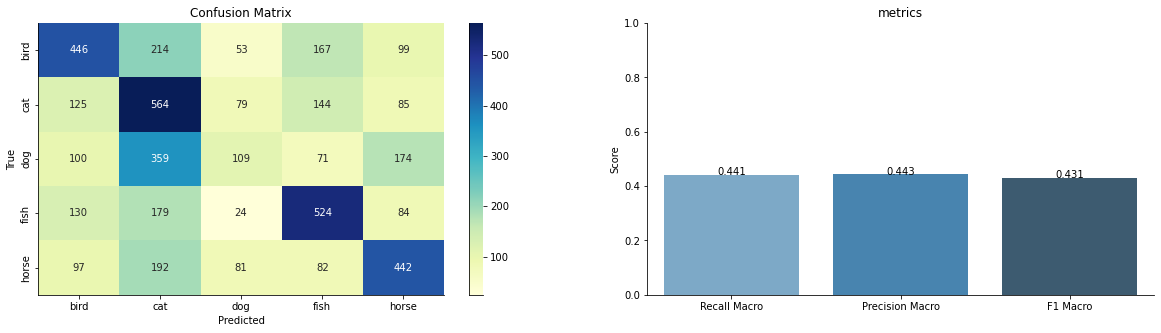

In [64]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Der Dropout performt leicht schlechter als die L2 Regularisierung. Aber immer noch besser Werte als gar keine Regularisierung. Das Problem bei der Vorhersage mit der Klasse der Hunden bleibt auf weiteres bestehen.

### 4.2.4 Model 9

Da wir mit L2 und Dropout bessere Resultate erzielen konnten, wie sieht es wohl aus wenn wir beides gleichzeitig anwenden:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001
- Regularisierung = Dropout(0.25) + L2 (weight_decay=0.001)

In [71]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,root=test_path,shuffle=False)

model = Drop_Net()
model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)

In [72]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 24s || Train Loss: 1.604 | Train Acc: 23.30% || Val. Loss: 1.595 |  Val. Acc: 27.44%
Epoch: 02 | Epoch Time: 2m 24s || Train Loss: 1.542 | Train Acc: 29.72% || Val. Loss: 1.493 |  Val. Acc: 33.35%
Epoch: 03 | Epoch Time: 2m 25s || Train Loss: 1.475 | Train Acc: 35.67% || Val. Loss: 1.446 |  Val. Acc: 36.03%
Epoch: 04 | Epoch Time: 2m 24s || Train Loss: 1.428 | Train Acc: 38.81% || Val. Loss: 1.408 |  Val. Acc: 39.51%
Epoch: 05 | Epoch Time: 2m 25s || Train Loss: 1.409 | Train Acc: 40.18% || Val. Loss: 1.398 |  Val. Acc: 40.39%
Epoch: 06 | Epoch Time: 2m 24s || Train Loss: 1.393 | Train Acc: 41.65% || Val. Loss: 1.380 |  Val. Acc: 41.82%
Epoch: 07 | Epoch Time: 2m 25s || Train Loss: 1.376 | Train Acc: 42.74% || Val. Loss: 1.364 |  Val. Acc: 43.38%
Epoch: 08 | Epoch Time: 2m 24s || Train Loss: 1.365 | Train Acc: 43.41% || Val. Loss: 1.359 |  Val. Acc: 43.76%
Epoch: 09 | Epoch Time: 2m 24s || Train Loss: 1.354 | Train Acc: 43.74% || Val. Loss: 1.344 |  Val. Acc:

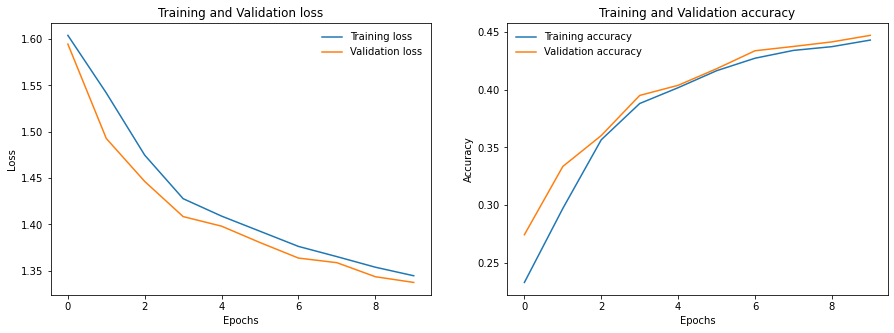

In [73]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Die Lossfunktion sieht für das Modell mit den Regularisierungen auch hier stabil aus.

In [68]:
PATH= "SGD_L2_Drop_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [69]:
PATH= "SGD_L2_Drop_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [70]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.344 | Test Acc: 44.61%


In [71]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

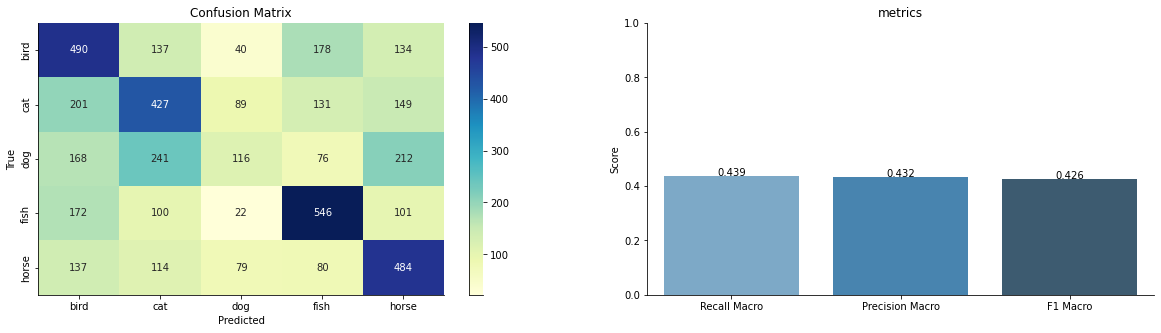

In [72]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Interessant das sich der F1 Score sogar schlechter ist als mit einer Regularisierung. Wir werden wohl in Zukunft nur mit der L2 Regularisierung fortfahren.

## 5  Benefits of Batchnorm BN (without REG, with SGD)

Grundsätzlich möchten man beim Training eines neuronalen Netzes die Daten als Teil des Pre-Processing in irgendeiner Weise im Voraus normalisieren oder standardisieren. Beide haben das Ziel, die Daten zu transformieren, um die Datenpunkte auf die gleiche Skala zu bringen. Somit wären unsere Input-Variablen normalisiert und vermeidet Instabilität, weil wir keine z.B. grossen Werte haben, dass zu Inbalance Gradient führen könnte und erhöhen zudem noch die Geschwindigkeit beim Trainieren. Aber es kann trotz normalisierten Daten zu einem anderen Problem kommen: Während des Trainings kann eines der Weights drastisch größer werden als die anderen. Dieser Weight kann dann dazu führen, dass die Outputs von dem entsprechenden Neuron gross ist wieder zu Ungleichgewicht führt. Genau hier kommt dann der Batchnorm (Batch Normalization). Er sorgt dafür, dass die Weights innerhalb des Netzwerks bei hohen oder niedrigen Werten nicht ins Ungleichgewicht geraten, da die Normalisierung innerhalb des Gradienten Prozess enthalten ist.

Dieses Hinzufügen der Batch-Norm zu unserem Modell kann die Geschwindigkeit des Trainierens erheblich erhöhen und die Möglichkeit verringern, dass große Gewichte abgesetzt werden, die den Trainingsprozess übermäßig beeinflussen.

Somit haben wir nicht nur normalisierte Inputdaten, sondern auch normalisierte Daten innerhalb des Netzwerkes.


### 5.1 Evaluation

### 5.1.1 Model 10

Hier wird jetzt die Architektur des CNN's angepasst und die Batchnorm hinzugefügt.
Die Parameter bleiben weiterhin unverändert:
    
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001

In [74]:
class NetBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv1_bn=nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv2_bn=nn.BatchNorm2d(16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 5)

    def forward(self, x):
        x = self.conv1_bn(self.conv1(x))
        x = self.pool(F.relu(x))
        x = self.conv2_bn(self.conv2(x))
        x = self.pool(F.relu(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

In [75]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=test_path,shuffle=False)

model = NetBN()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [76]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 24s || Train Loss: 1.493 | Train Acc: 33.78% || Val. Loss: 1.422 |  Val. Acc: 39.00%
Epoch: 02 | Epoch Time: 2m 25s || Train Loss: 1.384 | Train Acc: 41.77% || Val. Loss: 1.381 |  Val. Acc: 41.11%
Epoch: 03 | Epoch Time: 2m 24s || Train Loss: 1.340 | Train Acc: 44.48% || Val. Loss: 1.342 |  Val. Acc: 43.32%
Epoch: 04 | Epoch Time: 2m 24s || Train Loss: 1.310 | Train Acc: 46.11% || Val. Loss: 1.304 |  Val. Acc: 46.05%
Epoch: 05 | Epoch Time: 2m 25s || Train Loss: 1.289 | Train Acc: 47.22% || Val. Loss: 1.293 |  Val. Acc: 47.10%
Epoch: 06 | Epoch Time: 2m 24s || Train Loss: 1.279 | Train Acc: 47.83% || Val. Loss: 1.362 |  Val. Acc: 44.37%
Epoch: 07 | Epoch Time: 2m 25s || Train Loss: 1.262 | Train Acc: 48.56% || Val. Loss: 1.290 |  Val. Acc: 47.61%
Epoch: 08 | Epoch Time: 2m 24s || Train Loss: 1.248 | Train Acc: 49.48% || Val. Loss: 1.262 |  Val. Acc: 48.11%
Epoch: 09 | Epoch Time: 2m 24s || Train Loss: 1.237 | Train Acc: 49.93% || Val. Loss: 1.276 |  Val. Acc:

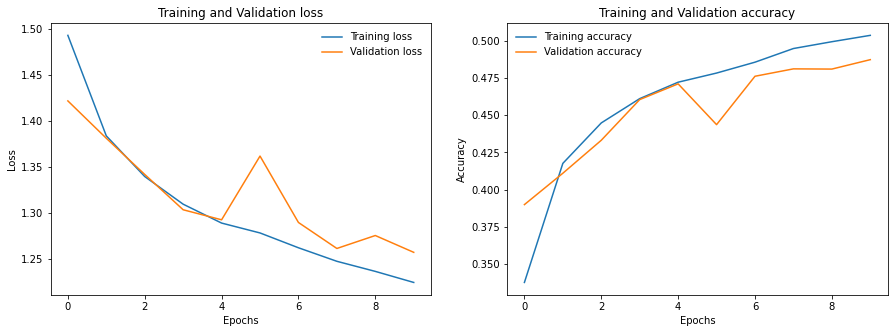

In [77]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Mit Batchnorm sehen wir keine starken Abweichungen im Vergleich zu den anderen Modellen. Der Loss nimm eine gute Kurve an. Auch hier würde man mit mehr Epochen zu einem besseren Resultat kommen.

In [80]:
PATH= "SGD_BN_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [81]:
PATH= "SGD_BN_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [82]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.253 | Test Acc: 49.33%


In [83]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

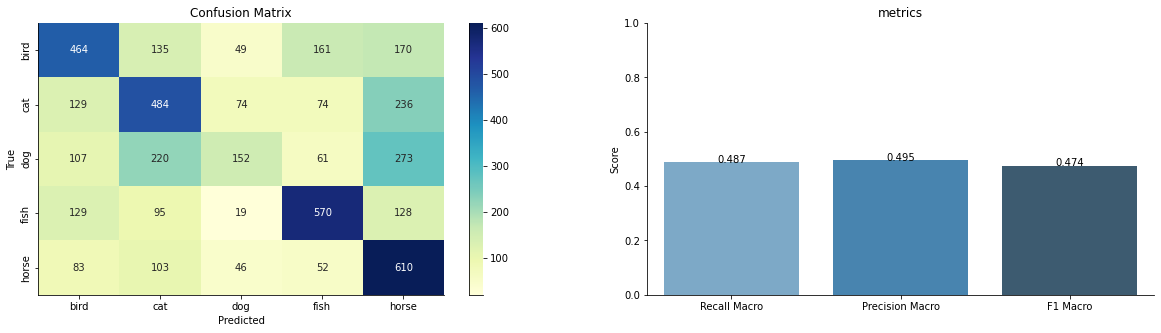

In [84]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Hier bei den Metriken sieht man, dass der Batchnorm doch was gebracht hat. wir konnten unser F1 Score steigern

### 5.2 Interpretieren

Mit Hilfe der Batchnorm konnten wir zwar auch keine Reduzierung der Trainingszeit erreichen, aber durch zwei Batch-Normalisierungen im Netzwerk konnte wahrscheinlich verhindert werden, das zu grosse Werte gesetzt werden die negativ auf das Modell schlagen. Dies ist vor allem bei den Metriken ersichtlich. Wir konnten dadurch eine Steigung von fast 15% erreichen mit dem F1 Score

## 6.  Benefits of Adam (without BN, without/with REG)

Adam ist ein Adaptive Moment Estimation Optimizer und wie der Name es schon sagt es optimiert das Modell. Grundsätzlich redet man bei Optimization wenn es die Zeit des Trainings reduziert und Adam ist einer der meist benutzten in Deep learning. Die Zeitreduktion kommt dadurch, weil mit Hilfe von Adam bei einem Gradient decent der Weg optimiert wird und schneller das Minimum findet.

Die Vorteile von Adam sind:
- Es kombiniert die Vorteile von zwei Optimizern zusammen: AdaGrad und RMSProp 
- Es ist einfach zu implementieren/configurieren
- Es benötigt weniger Speicherplatz
- Es ist effizienter/schneller beim Rechnen
- Es ist gut bei grossen Datensetz und Parametern
- Es funktioniert gut bei noisy gradients

### 6.1 Evaluation

### 6.1.1 Model 11

Dieses Modell wirt mid Adam optimiert statt mit SGD wie die anderen Modelle oben dran.
Diese Modell ist noch nicht regularisiert.
Die Parameter bleiben weiterhin unverändert:
    
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001
- Regularisierung = Keine

In [78]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer  = optim.Adam(model.parameters(), lr=learning_rate)

In [79]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 25s || Train Loss: 1.420 | Train Acc: 39.70% || Val. Loss: 1.365 |  Val. Acc: 42.25%
Epoch: 02 | Epoch Time: 2m 24s || Train Loss: 1.349 | Train Acc: 43.95% || Val. Loss: 1.352 |  Val. Acc: 43.18%
Epoch: 03 | Epoch Time: 2m 24s || Train Loss: 1.309 | Train Acc: 46.14% || Val. Loss: 1.297 |  Val. Acc: 46.82%
Epoch: 04 | Epoch Time: 2m 24s || Train Loss: 1.275 | Train Acc: 47.99% || Val. Loss: 1.282 |  Val. Acc: 48.01%
Epoch: 05 | Epoch Time: 2m 24s || Train Loss: 1.246 | Train Acc: 49.29% || Val. Loss: 1.270 |  Val. Acc: 47.21%
Epoch: 06 | Epoch Time: 2m 24s || Train Loss: 1.219 | Train Acc: 50.65% || Val. Loss: 1.263 |  Val. Acc: 48.66%
Epoch: 07 | Epoch Time: 2m 24s || Train Loss: 1.193 | Train Acc: 52.10% || Val. Loss: 1.249 |  Val. Acc: 49.14%
Epoch: 08 | Epoch Time: 2m 25s || Train Loss: 1.164 | Train Acc: 53.25% || Val. Loss: 1.258 |  Val. Acc: 49.50%
Epoch: 09 | Epoch Time: 2m 24s || Train Loss: 1.139 | Train Acc: 54.46% || Val. Loss: 1.280 |  Val. Acc:

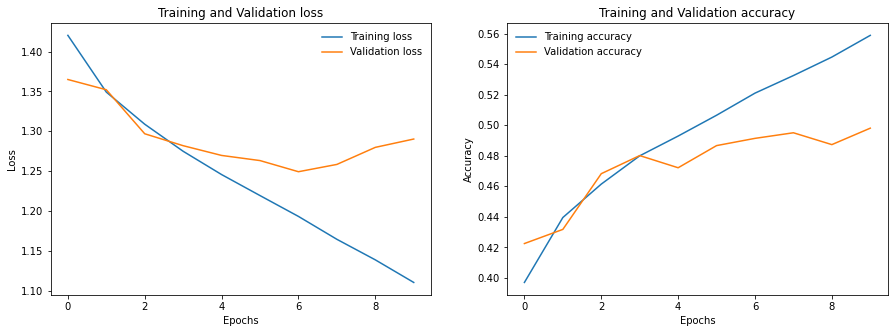

In [80]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Adam Optimizer ist sehr stark. Das erkennen wir am schnellen Sinken der Loss und das Steigen der Accuracy. Hier fehlt klar die Regularisierung. Das Modell wird zu Overgefittet.

In [88]:
PATH= "Adam_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [89]:
PATH= "Adam_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [90]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.302 | Test Acc: 49.07%


In [91]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

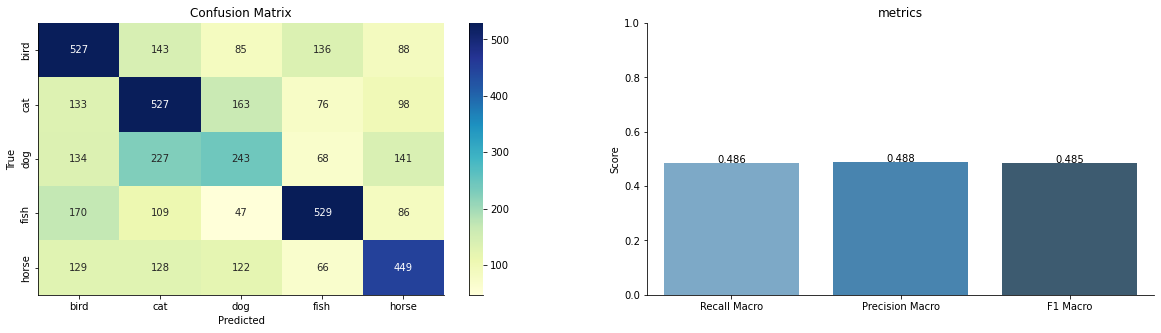

In [92]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Trotz des stark Overgefittem Modell, schlägt sich Adam gut. Der F1 Score ist so hoch wie noch nie mit diesem Netzwerk.

### 6.1.2 Model 12

Hier kommt jetzt noch mal ein Modell mit de mAdam Optimizer. Diese mal werden wir eine L2 regularisierung einführen
Die Parameter bleiben weiterhin unverändert:
    
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 10
- Learningrate = 0.001
- Regularisierung = L2 (weight_decay=0.001)

In [81]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 10
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer  = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [82]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 24s || Train Loss: 1.410 | Train Acc: 40.24% || Val. Loss: 1.355 |  Val. Acc: 43.12%
Epoch: 02 | Epoch Time: 2m 24s || Train Loss: 1.348 | Train Acc: 44.06% || Val. Loss: 1.319 |  Val. Acc: 45.52%
Epoch: 03 | Epoch Time: 2m 24s || Train Loss: 1.317 | Train Acc: 45.90% || Val. Loss: 1.306 |  Val. Acc: 46.57%
Epoch: 04 | Epoch Time: 2m 24s || Train Loss: 1.292 | Train Acc: 47.31% || Val. Loss: 1.295 |  Val. Acc: 47.81%
Epoch: 05 | Epoch Time: 2m 24s || Train Loss: 1.272 | Train Acc: 48.41% || Val. Loss: 1.274 |  Val. Acc: 48.08%
Epoch: 06 | Epoch Time: 2m 26s || Train Loss: 1.256 | Train Acc: 49.23% || Val. Loss: 1.245 |  Val. Acc: 49.58%
Epoch: 07 | Epoch Time: 2m 24s || Train Loss: 1.238 | Train Acc: 50.12% || Val. Loss: 1.255 |  Val. Acc: 49.31%
Epoch: 08 | Epoch Time: 2m 24s || Train Loss: 1.224 | Train Acc: 50.88% || Val. Loss: 1.237 |  Val. Acc: 50.31%
Epoch: 09 | Epoch Time: 2m 24s || Train Loss: 1.210 | Train Acc: 51.64% || Val. Loss: 1.258 |  Val. Acc:

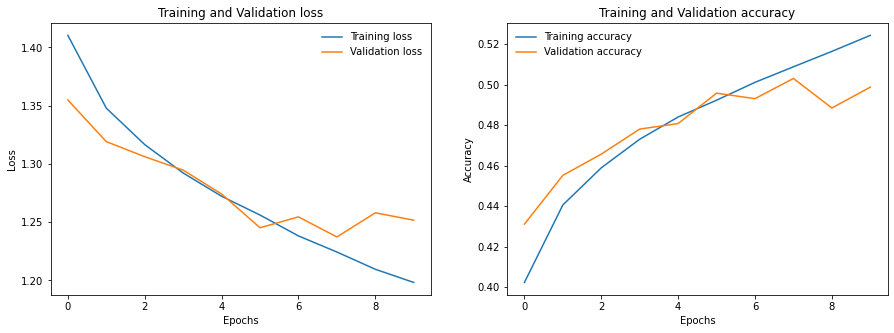

In [83]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Eine gute Abhilfe gegen das Overfitten verschafft und die Regularisierung. Diese Grafiken zeigen einen pralleren verlauf der Werte mit der L2 Regularisierung.

In [142]:
PATH= "Adam_L2_32ba_10ep_001lr"
torch.save(model.state_dict(), PATH)

In [143]:
PATH= "Adam_L2_32ba_10ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [144]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.259 | Test Acc: 49.22%


In [145]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

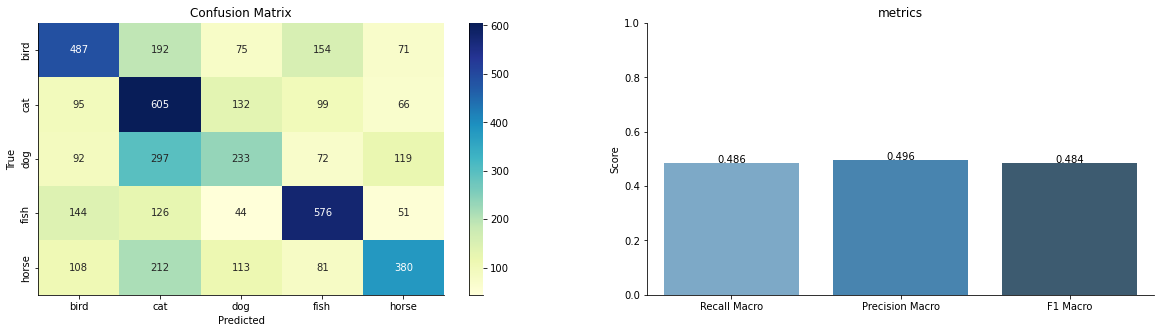

In [146]:
metric_evaluation(labels, pred_labels)

Beobachtung:

Trotz Regularisierung konnten wir auf den ersten Anhieb keine grossen Änderung der Metriken erkennen. Villeicht brauchen wir ja mal viele Epochen.

### 6.1.3 Model 13

Als nächstes trainieren wir mit den gleichen Parametern, diesmal einfach mit noch mehr Epochen. Hoffentlich können wie dadurch ein F1-Score von über 0.5 erreichen wie das AlexNet.
Die Parameter:
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 25
- Learningrate = 0.001
- Regularisierung = L2 (weight_decay=0.001)

In [84]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 25
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=train_path,shuffle=True)
valloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=val_path,shuffle=False)
testloader = image_loader(batch_size = batch_size,num_workers=num_workers,root=test_path,shuffle=False)

model = Net()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer  = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [85]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 24s || Train Loss: 1.429 | Train Acc: 38.75% || Val. Loss: 1.390 |  Val. Acc: 41.62%
Epoch: 02 | Epoch Time: 2m 24s || Train Loss: 1.361 | Train Acc: 43.54% || Val. Loss: 1.355 |  Val. Acc: 43.56%
Epoch: 03 | Epoch Time: 2m 24s || Train Loss: 1.335 | Train Acc: 44.87% || Val. Loss: 1.419 |  Val. Acc: 41.60%
Epoch: 04 | Epoch Time: 2m 24s || Train Loss: 1.310 | Train Acc: 46.38% || Val. Loss: 1.311 |  Val. Acc: 46.31%
Epoch: 05 | Epoch Time: 2m 24s || Train Loss: 1.288 | Train Acc: 47.57% || Val. Loss: 1.292 |  Val. Acc: 46.64%
Epoch: 06 | Epoch Time: 2m 24s || Train Loss: 1.272 | Train Acc: 48.38% || Val. Loss: 1.330 |  Val. Acc: 44.26%
Epoch: 07 | Epoch Time: 2m 25s || Train Loss: 1.258 | Train Acc: 49.02% || Val. Loss: 1.280 |  Val. Acc: 47.14%
Epoch: 08 | Epoch Time: 2m 25s || Train Loss: 1.244 | Train Acc: 49.94% || Val. Loss: 1.274 |  Val. Acc: 47.33%
Epoch: 09 | Epoch Time: 2m 24s || Train Loss: 1.233 | Train Acc: 50.14% || Val. Loss: 1.262 |  Val. Acc:

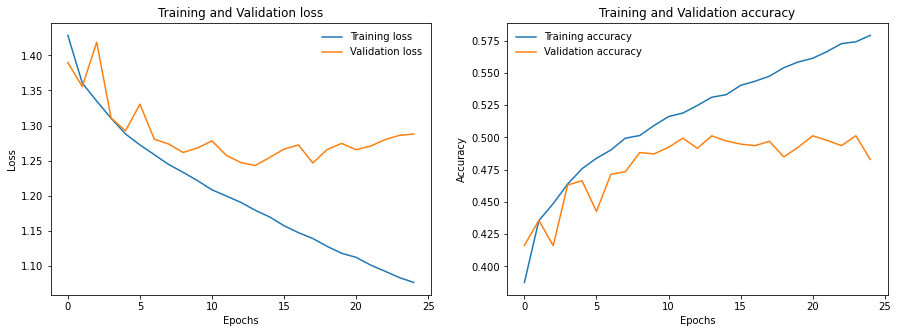

In [86]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Mehr Epochen hat uns nicht viel mehr Nutzen gebracht. Das Modell wurde mir der anzahl Epochen immer mehr Overfittet, und das Validation-Datensatz konnte nicht mehr verbessert werden.

In [23]:
PATH= "Adam_L2_32ba_25ep_001lr"
torch.save(model.state_dict(), PATH)

In [24]:
PATH= "Adam_L2_32ba_25ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.317 | Test Acc: 50.00%


In [26]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

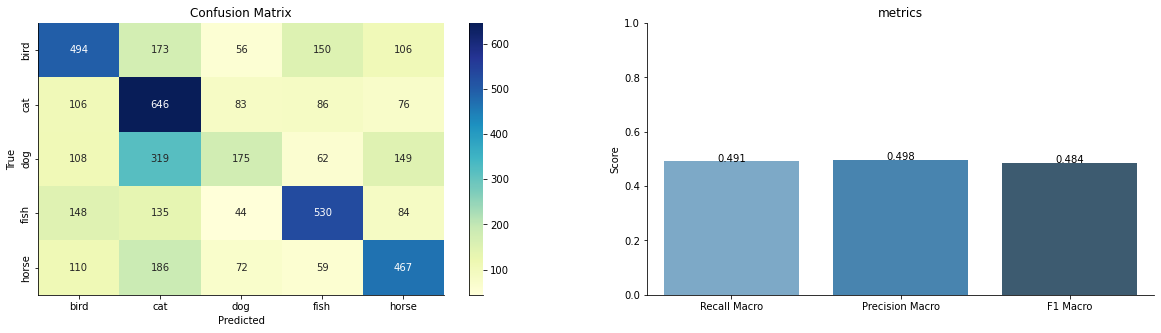

In [27]:
metric_evaluation(labels, pred_labels)

Beobachtung:
    
Wie erwartet, sehen wir auch im Testdatensatz bei den Metriken keinen Unterschied mehr. Einen F1 Score von 0.5 konnte nicht erreicht werden.

### 6.1.4 Model 14

Zum Schluss nehmen wir wieder den AlexNet mit 25 Epochen. Dieses Mal aber mit Adam-Optimizer und L2 Regularisierung.
- Anzahl Worker = 8
- Batchgrösse = 32
- Epochen = 25
- Learningrate = 0.001
- Regularisierung = L2 (weight_decay=0.001)

In [15]:
train_path='Data/train/'
val_path='Data/val/'
test_path='Data/test/'
batch_size = 32
epochs = 25
num_workers = 8
learning_rate = 0.001

trainloader = image_loader(image_size = 224, batch_size = batch_size,root=train_path,shuffle=True)
valloader = image_loader(image_size = 224,batch_size = batch_size,root=val_path,shuffle=False)
testloader = image_loader(image_size = 224,batch_size = batch_size,root=test_path,shuffle=False)

model = AlexNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer  = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

In [96]:
model, train_losses, train_accuracy, valid_losses, valid_accuracy = train_epoch(epochs, model, trainloader, optimizer, criterion, device)

Epoch: 01 | Epoch Time: 2m 57s || Train Loss: 1.696 | Train Acc: 28.60% || Val. Loss: 1.466 |  Val. Acc: 33.48%
Epoch: 02 | Epoch Time: 2m 40s || Train Loss: 1.469 | Train Acc: 35.31% || Val. Loss: 1.445 |  Val. Acc: 35.07%
Epoch: 03 | Epoch Time: 2m 41s || Train Loss: 1.427 | Train Acc: 38.29% || Val. Loss: 1.402 |  Val. Acc: 37.73%
Epoch: 04 | Epoch Time: 2m 41s || Train Loss: 1.356 | Train Acc: 43.49% || Val. Loss: 1.319 |  Val. Acc: 46.01%
Epoch: 05 | Epoch Time: 2m 41s || Train Loss: 1.302 | Train Acc: 46.94% || Val. Loss: 1.275 |  Val. Acc: 48.25%
Epoch: 06 | Epoch Time: 2m 41s || Train Loss: 1.258 | Train Acc: 48.98% || Val. Loss: 1.283 |  Val. Acc: 47.24%
Epoch: 07 | Epoch Time: 2m 41s || Train Loss: 1.226 | Train Acc: 50.69% || Val. Loss: 1.205 |  Val. Acc: 52.13%
Epoch: 08 | Epoch Time: 2m 41s || Train Loss: 1.196 | Train Acc: 52.07% || Val. Loss: 1.187 |  Val. Acc: 52.97%
Epoch: 09 | Epoch Time: 2m 40s || Train Loss: 1.173 | Train Acc: 53.59% || Val. Loss: 1.152 |  Val. Acc:

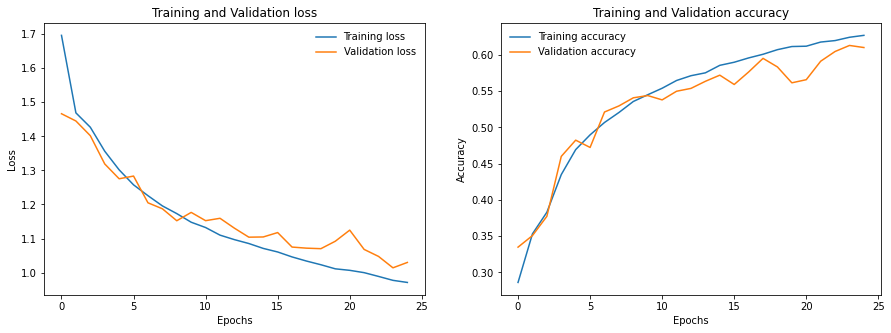

In [97]:
loss_acc_function(train_losses,valid_losses,train_accuracy,valid_accuracy)

Beobachtung:

Die Accuracy steigt gut an und auch der Loss von Training und Validation-Datensatz sinken etwa gleich. Eine ideale Kurve sollte aber einen stärkeren Bogen machen.

In [98]:
PATH= "Adam_L2_32ba_25ep_001lr"
torch.save(model.state_dict(), PATH)

In [17]:
PATH= "Adam_L2_32ba_25ep_001lr"
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [18]:
test_loss, test_acc = evaluate(model, testloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 1.052 | Test Acc: 60.15%


In [114]:
images, labels, probs = get_predictions(model, testloader, device)

pred_labels = torch.argmax(probs, 1)

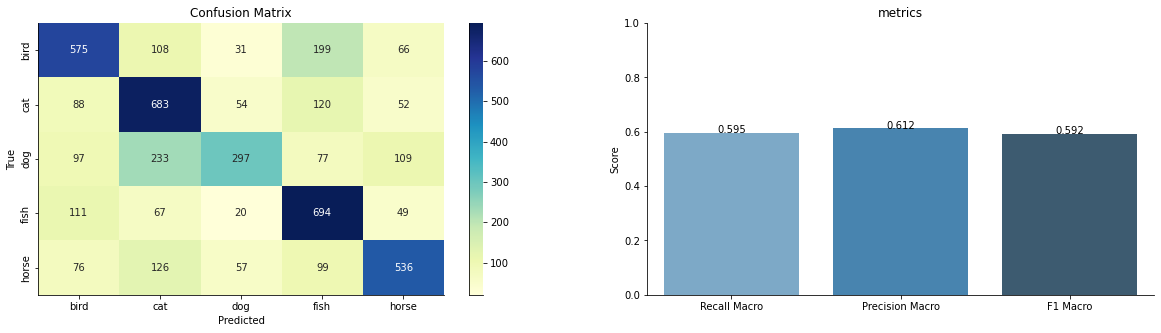

In [102]:
metric_evaluation(labels, pred_labels)

Beobachtung:
    
Die Metriken zeigen ein gutes Resultat. Bis jetzt ist das unser bestes Modell. Auch die Vorhersage der Klasse der Hunde ist so stark wie noch nie. Der F1 Score erreicht hier einen Wert von fast 0.6!

Interessant wäre es doch noch zu wissen, welche Bilder  falsch predicted werden?

In [121]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [169]:
def false_predicted(incorrect_examples):
    fig = plt.figure(figsize = (10, 10))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1)
        image, true_label, probs = incorrect_examples[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        ax.imshow(np.clip(image.permute(1, 2, 0),0, 1))
        ax.set_title('True label: {} \nPred label: {}'.format(classes[true_label],classes[incorrect_label]))
        ax.axis('off')
classes = ["bird","cat","dog","fish","horse"]

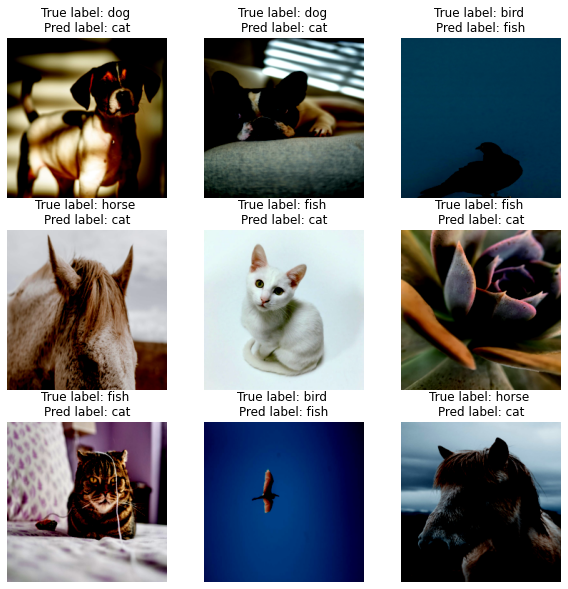

In [170]:
false_predicted(incorrect_examples)

Beobachtung:
    
Hier sehen wir verschiedene Beispiele, wieso das Modell wohl falsch klassifiziert hat. Die zwei Bilder von den Vögeln werden wahrscheinlich wegen dem dunkellauen Hintergrund das eine ähnliche Farbe wie das Wasser hat beeinflusst. Unten links ist tatsächlich sogar eine Katze zu sehen und unser Datensatz hat hier einen Fehler drin. Zudem sehen wir auch ein Bild wo eine Pflanze drauf ist. Natürlich ist dies auch für den Menschen nicht zu erkennen, dass es sich dabei um einen Fisch handeln sollte...


## 7. Zusammenfassung

In diesem Notebook haben wir mehrere Modelle mit unterschiedlichem Parameter, Regularisierung, Optimizern und CNN's erstellt. Wir sehen es gibt unzählige Variationen wie man das Modell konfigurieren kann. Leider geht das Trainieren mit diesem Datensatz sehr lange, weshalb ich die Anzahl Modelle stark reduzieren musste. Damit dieses Notebook einmal durchläuft, braucht es über 8 Stunden. Zudem musste ich während des erstellen des Notebooks die Modelle mehrmals trainiert, damit ich noch zusätzliche Informationen sammeln, Änderungen machen und Fehler korrigieren konnte. Zusätzliche Ansätze, die wir weiterverfolgen könnten, wären:
- Unterschiedliche Grössen der Input-Bilder
- Verhalten der unterschiedlichen Modelle mit noch mehr Epochen
- Mehrere verschiedene Architekturen des Netzwerkes durchtesten und vergleichen.
- Cross Validation der Modelle, um die Fehlerabschätzung zu beobachten
- Unterschiedliche Lambda-Werte bei der L1 Regularisierung
- Unterschiedliche Weight-decay bei der L2 Rgularisierung
- Unterschiedliche Rate bei der Dropout Regularisierung (1 = kein dropout, 0 = kein output vom layer)
- Verwendung der Batchnorm in unterschiedlichen Layers 
- Unterschiedliche Regularisierungen mit Adam-Optimizer

Das beste Modell war trotz allem immer noch das AlexNet, auch wenn die Trainingszeit minim länger war. Wir können daraus schliessen, dass das gewählte oder erstellte Netzwerk den stärksten Einfluss hat wie das Modell am Schluss performt. Regularisierungen und Normalisierungen bringen klar auch seine Vorteile und verbessern das Modell. Dies können wir ebenfalls bestätigen.

## 8. Quellenangaben
- https://colab.research.google.com/github/goodboychan/chans_jupyter/blob/main/_notebooks/2020-07-29-01-Convolutional-Neural-Networks-in-PyTorch.ipynb#scrollTo=nBijEYjG8rTF
- https://developpaper.com/example-of-pytorch-implementing-alexnet/
- https://github.com/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb
- https://hackmd.io/@ambersun1234/ml_gradient_descent
- https://learnopencv.com/pytorch-for-beginners-image-classification-using-pre-trained-models/
- https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48
- https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c
- https://towardsdatascience.com/batch-normalisation-in-deep-neural-network-ce65dd9e8dbf
- https://towardsdatascience.com/regularization-in-deep-learning-l1-l2-and-dropout-377e75acc036
- https://www.analyticsvidhya.com/blog/2021/03/introduction-to-batch-normalization/
- https://www.pluralsight.com/guides/image-classification-with-pytorch